<a href="https://colab.research.google.com/github/tasdid25/Deep-Learning/blob/main/how_to_track_and_count_vehicles_with_yolov8_and_supervison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# YOLOv8 Tracking and Counting

---

[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/OS5qI9YBkfk)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/yolov8-tracking-and-counting/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/notebooks)

Ultralytics YOLOv8 is the latest version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics. The YOLOv8 model is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and image segmentation tasks. It can be trained on large datasets and is capable of running on a variety of hardware platforms, from CPUs to GPUs.

## ⚠️ Disclaimer

This is an updated version of our [how-to-track-and-count-vehicles-with-yolov8](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-track-and-count-vehicles-with-yolov8.ipynb) notebook, using the latest [supervision](https://github.com/roboflow/supervision) APIs.

## Accompanying Blog Post

We recommend that you follow along in this notebook while reading the [blog post](https://blog.roboflow.com/yolov8-tracking-and-counting/) on how to train YOLOv8 Tracking and Counting, concurrently.

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Download video
- Install YOLOv8
- Install ByteTrack
- Install Roboflow Supervision
- Tracking utils
- Load pre-trained YOLOv8 model
- Predict and annotate single frame
- Predict and annotate whole video

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sat Oct  5 18:42:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Download video

In [ ]:
!pip install -q gdown
%cd {HOME}
!gdown '1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-'

/content
Downloading...
From: https://drive.google.com/uc?id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-
To: /content/vehicle-counting.mp4
100% 35.3M/35.3M [00:00<00:00, 235MB/s]


In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"

## Install YOLOv8

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.5 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 36.4/112.6 GB disk)


## Install Roboflow Supervision

In [ ]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.24.0


## Load pre-trained YOLOv8 model

In [ ]:
MODEL = "yolov8x.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:01<00:00, 91.4MB/s]


YOLOv8x summary (fused): 268 layers, 68,200,608 parameters, 0 gradients, 257.8 GFLOPs


## Predict and annotate single frame

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names

# class_ids of interest - car, motorcycle, bus and truck
selected_classes = [2, 3, 5, 7]

In [ ]:
import supervision as sv
import numpy as np

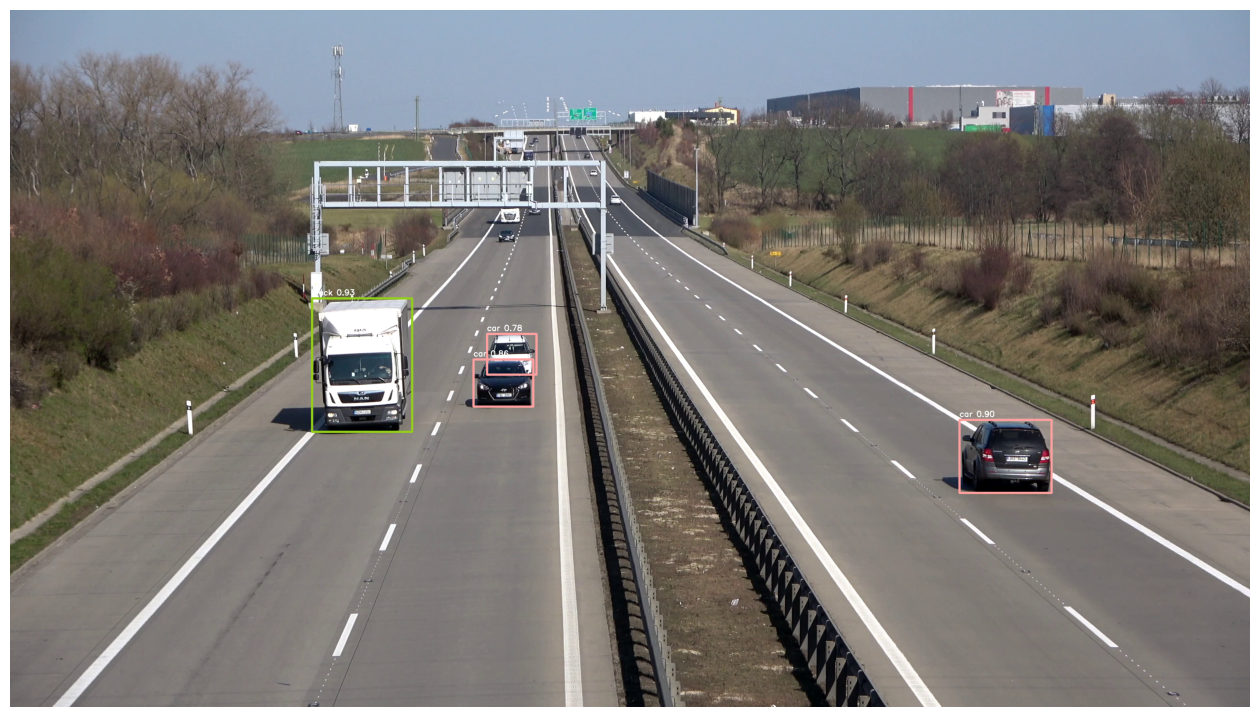

In [ ]:
import supervision as sv
import numpy as np
import cv2  # For text overlays if needed

# Load video frames generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Create instance of BoxAnnotator (text_thickness and text_scale not supported in 0.24.0)
box_annotator = sv.BoxAnnotator(thickness=5)

# Acquire first video frame
iterator = iter(generator)
frame = next(iterator)

# Model prediction on single frame and conversion to supervision Detections
results = model(frame, verbose=False)[0]

# Convert to Detections object
detections = sv.Detections.from_ultralytics(results)

# Filter detections by selected class IDs
detections = detections[np.isin(detections.class_id, selected_classes)]

# Format custom labels (e.g., class name and confidence score)
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# Annotate the frame (without labels)
annotated_frame = box_annotator.annotate(scene=frame, detections=detections)

# Manually add labels using OpenCV
for detection, label in zip(detections.xyxy, labels):
    x1, y1, x2, y2 = map(int, detection)  # Get box coordinates
    cv2.putText(
        annotated_frame, label, (x1, y1 - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2
    )


# Display the annotated frame using supervision's plot_image
%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))


Help on class BoxAnnotator in module supervision.annotators.core:

class BoxAnnotator(supervision.annotators.base.BaseAnnotator)
 |  BoxAnnotator(color: Union[supervision.draw.color.Color, supervision.draw.color.ColorPalette] = ColorPalette(colors=[Color(r=163, g=81, b=251), Color(r=255, g=64, b=64), Color(r=255, g=161, b=160), Color(r=255, g=118, b=51), Color(r=255, g=182, b=51), Color(r=209, g=212, b=53), Color(r=76, g=251, b=18), Color(r=148, g=207, b=26), Color(r=64, g=222, b=138), Color(r=27, g=150, b=64), Color(r=0, g=214, b=193), Color(r=46, g=156, b=170), Color(r=0, g=196, b=255), Color(r=54, g=71, b=151), Color(r=102, g=117, b=255), Color(r=0, g=25, b=239), Color(r=134, g=58, b=255), Color(r=83, g=0, b=135), Color(r=205, g=58, b=255), Color(r=255, g=151, b=202), Color(r=255, g=57, b=201)]), thickness: int = 2, color_lookup: supervision.annotators.utils.ColorLookup = <ColorLookup.CLASS: 'class'>)
 |  
 |  A class for drawing bounding boxes on an image using provided detections.

## Predict and annotate whole video

In [ ]:
# settings
LINE_START = sv.Point(50, 1500)
LINE_END = sv.Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result-with-counter.mp4"

In [ ]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

In [ ]:
import supervision as sv
import numpy as np
import cv2

# Create BYTETracker instance (removing track_thresh)
byte_tracker = sv.ByteTrack(frame_rate=30)

# Create VideoInfo instance to get details about the video
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Create frame generator to read frames from the video
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Create LineZone instance (previously called LineCounter)
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# Create instance of BoxAnnotator (without text thickness/scale in this version)
box_annotator = sv.BoxAnnotator(thickness=4)

# Create TraceAnnotator instance
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# Create LineZoneAnnotator instance (text_thickness and text_scale removed)
line_zone_annotator = sv.LineZoneAnnotator(thickness=4)

# Define callback function for processing video frames
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # Model prediction on a single frame and convert to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    # Filter detections by selected class IDs
    detections = detections[np.isin(detections.class_id, selected_classes)]

    # Track detections using BYTETracker
    detections = byte_tracker.update_with_detections(detections)

    # Generate labels (class names, tracker IDs, and confidence scores)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    # Annotate frame with traces
    annotated_frame = trace_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )

    # Annotate frame with bounding boxes and labels
    annotated_frame = box_annotator.annotate(
        scene=annotated_frame,
        detections=detections
    )

    # Manually add labels using OpenCV for text thickness/scale customization
    for detection, label in zip(detections.xyxy, labels):
        x1, y1, x2, y2 = map(int, detection)  # Box coordinates
        cv2.putText(
            annotated_frame, label, (x1, y1 - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2
        )

    # Update LineZone to detect if objects cross the line
    line_zone.trigger(detections)

    # Return the annotated frame, including LineZone annotations
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# Process the entire video
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback
)


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.